# CZĘŚĆ 2

## OPIS ZESTAWU DANYCH
Dane składają się z informacji o przylotach i odlotach wszystkich lotów komercyjnych w USA od października 1987 do kwietnia 2008 – przede wszystkim o ich opóźnieniach. \
Zbiór danych jest bardzo duży (120mln rekordów, 12GB danych) – na potrzeby projektu wykorzystamy jedynie dane z roku 2007 co ograniczy rozmiar przetwarzanych danych.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import zipfile

zf = zipfile.ZipFile("./data_mow.zip")
namelist = zf.namelist()[1:]
dfs = [pd.read_csv(zf.open(f)) for f in namelist]
data = pd.concat(dfs, ignore_index=True)
data = data[data["Year"] == 2007]
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data.head())

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.00,1225,1341.00,1340,WN,2891,N351,69.00,75.00,54.00,1.00,7.00,SMF,ONT,389,4,11,0,NaN,0,0,0,0,0,0
1,2007,1,1,1,1918.00,1905,2043.00,2035,WN,462,N370,85.00,90.00,74.00,8.00,13.00,SMF,PDX,479,5,6,0,NaN,0,0,0,0,0,0
2,2007,1,1,1,2206.00,2130,2334.00,2300,WN,1229,N685,88.00,90.00,73.00,34.00,36.00,SMF,PDX,479,6,9,0,NaN,0,3,0,0,0,31
3,2007,1,1,1,1230.00,1200,1356.00,1330,WN,1355,N364,86.00,90.00,75.00,26.00,30.00,SMF,PDX,479,3,8,0,NaN,0,23,0,0,0,3
4,2007,1,1,1,831.00,830,957.00,1000,WN,2278,N480,86.00,90.00,74.00,-3.00,1.00,SMF,PDX,479,3,9,0,NaN,0,0,0,0,0,0


In [3]:
data.drop(
    ['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode', 'FlightNum', 'TaxiIn', 'TaxiOut', 'DepTime',
     'ArrTime', 'ActualElapsedTime', 'AirTime', 'DepDelay', 'ArrDelay'], inplace=True, axis=1)

In [4]:
for column in ['CRSDepTime', 'CRSArrTime']:
    data[column] = data[column] // 100 + (data[column] % 100) / 60

In [5]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data.describe())

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7452221.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00
mean,2007.00,6.51,15.73,3.93,13.48,15.15,127.25,719.81,0.02,0.00,3.87,0.77,3.78,0.02,5.10
std,0.00,3.43,8.78,1.99,4.66,4.82,70.36,562.31,0.15,0.05,20.84,9.62,16.18,1.08,21.28
min,2007.00,1.00,1.00,1.00,0.00,0.00,-1240.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2007.00,4.00,8.00,2.00,9.50,11.25,77.00,319.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2007.00,7.00,16.00,4.00,13.37,15.33,110.00,569.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2007.00,9.00,23.00,6.00,17.33,19.10,156.00,946.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2007.00,12.00,31.00,7.00,23.98,24.00,1430.00,4962.00,1.00,1.00,2580.00,1429.00,1386.00,382.00,1031.00


In [6]:
data["Year"] = data["Year"].astype("int")

## PROBLEMY Z DANYMI - DANE BRAKUJĄCE, NIEPRAWIDŁOWE, ODSTAJĄCE

### SPRAWDZENIE POPRAWNOŚCI TYPÓW DANYCH

In [7]:
# data = pd.read_parquet("./data_mow_2007.parquet")

In [8]:
data.dtypes

Year                   int32
Month                  int64
DayofMonth             int64
DayOfWeek              int64
CRSDepTime           float64
CRSArrTime           float64
CRSElapsedTime       float64
Distance               int64
Cancelled              int64
Diverted               int64
CarrierDelay           int64
WeatherDelay           int64
NASDelay               int64
SecurityDelay          int64
LateAircraftDelay      int64
dtype: object

Jak widać wyżej - wszystkie dane występują w poprawnym formacie.

### NAPRAWA WIERSZY Z PUSTYMI DANYMI

In [9]:
data["CRSElapsedTime"] = data["CRSElapsedTime"].map(lambda v: np.NAN if v < 0 else v)

In [10]:
data_with_nulls = data.copy()
np.random.seed(42)
data_with_nulls["Distance"] = data_with_nulls["Distance"].mask(np.random.random(data_with_nulls.shape[0]) < 0.1)
data_with_nulls["WeatherDelay"] = data_with_nulls["WeatherDelay"].mask(np.random.random(data_with_nulls.shape[0]) < 0.1)

In [11]:
np.sum(data_with_nulls.isna())

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
CRSDepTime                0
CRSArrTime                0
CRSElapsedTime          996
Distance             746296
Cancelled                 0
Diverted                  0
CarrierDelay              0
WeatherDelay         743989
NASDelay                  0
SecurityDelay             0
LateAircraftDelay         0
dtype: int64

##### PROSTA METODA - WYPEŁNIANIE 0

In [12]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["CRSElapsedTime"].describe())

count   7452219.00
mean        127.25
std          70.36
min           1.00
25%          77.00
50%         110.00
75%         156.00
max        1430.00
Name: CRSElapsedTime, dtype: float64

In [13]:
data_with_nulls["CRSElapsedTime"].fillna(0, inplace=True)

In [14]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["CRSElapsedTime"].describe())

count   7453215.00
mean        127.23
std          70.37
min           0.00
25%          77.00
50%         110.00
75%         156.00
max        1430.00
Name: CRSElapsedTime, dtype: float64

##### ROZKŁAD ZMIENNEJ

In [15]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data["Distance"].describe())

count   7453215.00
mean        719.81
std         562.31
min          11.00
25%         319.00
50%         569.00
75%         946.00
max        4962.00
Name: Distance, dtype: float64

In [16]:
from scipy.stats import gaussian_kde

# estimate density
density = gaussian_kde(data["Distance"])

# use density to imput missing values
data_with_nulls["Distance"].fillna(density.resample(1)[0][0], inplace=True)

In [17]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["Distance"].describe())

count   7453215.00
mean        893.01
std         744.25
min          11.00
25%         337.00
50%         622.00
75%        1127.00
max        4962.00
Name: Distance, dtype: float64

##### Regresja

In [18]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["WeatherDelay"].describe())

count   6709226.00
mean          0.77
std           9.57
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        1429.00
Name: WeatherDelay, dtype: float64

In [19]:
# build regression model for WeatherDelay
from sklearn.linear_model import LinearRegression

columns = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
           'CRSElapsedTime', 'Distance', 'Cancelled', 'Diverted', 'CarrierDelay',
           'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

model = LinearRegression()
model = model.fit(data_with_nulls.dropna()[columns], data_with_nulls["WeatherDelay"].dropna())

In [20]:
# impute missing values using regression model
# for each row with missing value in WeatherDelay
data_with_nulls.loc[data_with_nulls["WeatherDelay"].isna(), "WeatherDelay"] = model.predict(
    data_with_nulls[data_with_nulls["WeatherDelay"].isna()][columns])

In [21]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["WeatherDelay"].describe())

count   7453215.00
mean          0.77
std           9.08
min          -6.00
25%           0.00
50%           0.00
75%           0.00
max        1429.00
Name: WeatherDelay, dtype: float64

In [22]:
# if value less than 0, set to 0
data_with_nulls["WeatherDelay"] = data_with_nulls["WeatherDelay"].map(lambda v: 0 if v < 0 else v)

In [23]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["WeatherDelay"].describe())

count   7453215.00
mean          0.77
std           9.08
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        1429.00
Name: WeatherDelay, dtype: float64

#### SKALOWANIE DANYCH

In [24]:
data_to_scale = data_with_nulls.copy()

data_minmax = data_to_scale.copy()
columns = [column for column in data_minmax.columns if column != 'Cancelled']
for column in columns:
    data_minmax[column] = (data_minmax[column] - data_minmax[column].min()) / (
                data_minmax[column].max() - data_minmax[column].min())

In [25]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data_minmax.describe())

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,0.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00
mean,NaN,0.50,0.49,0.49,0.56,0.63,0.09,0.18,0.02,0.00,0.00,0.00,0.00,0.00,0.00
std,NaN,0.31,0.29,0.33,0.19,0.20,0.05,0.15,0.15,0.05,0.01,0.01,0.01,0.00,0.02
min,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,0.27,0.23,0.17,0.40,0.47,0.05,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,NaN,0.55,0.50,0.50,0.56,0.64,0.08,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,NaN,0.73,0.73,0.83,0.72,0.80,0.11,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,NaN,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [26]:
data_standard = data_to_scale.copy()
columns = [column for column in data_minmax.columns if column != 'Cancelled']
for column in columns:
    data_standard[column] = (data_standard[column] - data_standard[column].mean()) / data_standard[column].std()

In [27]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data_standard.describe())

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,0.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00
mean,NaN,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.02,0.00,-0.00,0.00,-0.00,-0.00,0.00
std,NaN,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.15,1.00,1.00,1.00,1.00,1.00,1.00
min,NaN,-1.61,-1.68,-1.47,-2.89,-3.14,-1.81,-1.19,0.00,-0.05,-0.19,-0.08,-0.23,-0.02,-0.24
25%,NaN,-0.73,-0.88,-0.97,-0.85,-0.81,-0.71,-0.75,0.00,-0.05,-0.19,-0.08,-0.23,-0.02,-0.24
50%,NaN,0.14,0.03,0.03,-0.02,0.04,-0.24,-0.36,0.00,-0.05,-0.19,-0.08,-0.23,-0.02,-0.24
75%,NaN,0.73,0.83,1.04,0.83,0.82,0.41,0.31,0.00,-0.05,-0.19,-0.08,-0.23,-0.02,-0.24
max,NaN,1.60,1.74,1.54,2.25,1.84,18.51,5.47,1.00,20.81,123.60,157.32,85.44,352.05,48.22


In [28]:
# data_standard.to_parquet("./data_mow_2007_standard.parquet")

In [29]:
# data_minmax.to_parquet("./data_mow_2007_minmax.parquet")

### PODZIAŁ DANYCH

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
data_standard = pd.read_parquet("./data_mow_2007_standard.parquet")
data_minmax = pd.read_parquet("./data_mow_2007_minmax.parquet")

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

columns =['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled']

def train_test_split(X, Y, test_size):
    train_pct_index = int((1 - test_size) * len(X))
    train_pct_indexY = int((1 - 0.20) * len(Y))

    trainDF_x = pd.DataFrame(X[:train_pct_index], columns = columns)
    trainDF_y = pd.DataFrame(Y[:train_pct_indexY], columns = columns)
    trainDF = trainDF_x.append(trainDF_y)
    trainDF = trainDF.sample(frac=1, random_state=42)
    trainDF = trainDF.to_numpy()

    testDF_x = pd.DataFrame(X[train_pct_index:], columns = columns)
    testDF_y = pd.DataFrame(Y[train_pct_indexY:], columns = columns)
    testDF = testDF_x.append(testDF_y)
    testDF = testDF.sample(frac=1, random_state=42)
    testDF = testDF.to_numpy()

    return trainDF[:, :-1], testDF[:, :-1], trainDF[:, -1:], testDF[:, -1:]



def splitOfData(dataInput, testSize):
    cancelled = dataInput['Cancelled']==1
    dataCancelled = dataInput[cancelled]
    dataNotCancelled = dataInput[~cancelled]
    return train_test_split(dataNotCancelled, dataCancelled, test_size=testSize)

data_for_training_standard = data_standard[['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime','CRSElapsedTime', 'Distance', 'Diverted', 'CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled']]
data_for_training_minmax = data_minmax[['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime','CRSElapsedTime', 'Distance', 'Diverted', 'CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled']]

x_train_standard, x_test_standard, y_train_standard, y_test_standard = splitOfData(data_for_training_standard, 0.2)
x_train_minmax, x_test_minmax, y_train_minmax, y_test_minmax = splitOfData(data_for_training_minmax, 0.2)

data_sets = [("standarized", x_train_standard, y_train_standard, x_test_standard, y_test_standard), ("min-max", x_train_minmax, y_train_minmax, x_test_minmax, y_test_minmax)]
print("")
print("x_train_standard: ", x_train_standard.shape)
print("x_test_standard: ", x_test_standard.shape)
print("y_train_standard: ", y_train_standard.shape)
print("y_test_standard: ", y_test_standard.shape)

print("")
print("x_train_minmax.shape: ", x_train_minmax.shape)
print("x_test_minmax.shape: ", x_test_minmax.shape)
print("y_train_minmax.shape: ", y_train_minmax.shape)
print("y_test_minmax.shape: ", y_test_minmax.shape)



x_train_standard:  (5962571, 13)
x_test_standard:  (1490644, 13)
y_train_standard:  (5962571, 1)
y_test_standard:  (1490644, 1)

x_train_minmax.shape:  (5962571, 13)
x_test_minmax.shape:  (1490644, 13)
y_train_minmax.shape:  (5962571, 1)
y_test_minmax.shape:  (1490644, 1)


### MIARY SKUTECZNOŚCI

In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def effectiveness_measures_classifier(y_test, predictions):
    acc=accuracy_score(y_test, predictions)
    print("Prediction Accuracy: ", acc)

    f1=f1_score(y_test, predictions)
    print("F1: ", f1)

    precision=precision_score(y_test, predictions)
    print("Precision: ", precision)

    recall=recall_score(y_test, predictions)
    print("Recall: ", recall)

    return acc, f1, precision, recall


### DECISION TREE CLASSIFIER

Decision Tree Classifier (standarized data):


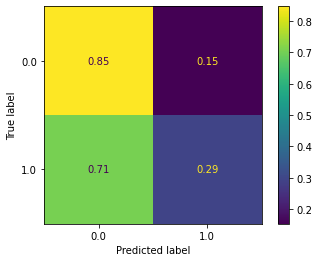

Prediction Accuracy:  0.8353979890570787
F1:  0.07156884632412204
Precision:  0.04074062905219988
Recall:  0.2941524105754277

Decision Tree Classifier (min-max data):


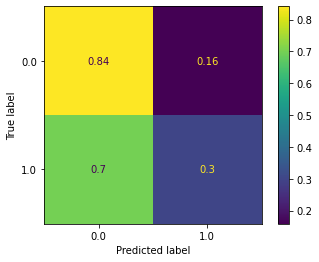

Prediction Accuracy:  0.8298507222381736
F1:  0.07082933405625609
Precision:  0.040142681549398714
Recall:  0.30068429237947125



In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

eff_dtc = []

for name, x_train, y_train, x_test, y_test in data_sets:
    dtc = DecisionTreeClassifier(max_depth=10, class_weight="balanced").fit(x_train, y_train)
    pred = dtc.predict(x_test)
    print(f"Decision Tree Classifier ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_dtc.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model drzewa decyzyjnego dość słabo poradził sobie z klasyfikacją odwołanych lotów. Poprawnie zostało zaklasyfikowane tylko około 30% próbek dodatnich. Trochę lepsze wyniki zostały osiągnięte dla danych przeskalowanych metodą min-max - poprawnie sklasyfikowane zostało o 1% więcej próbek dodatnich. Jeśli chodzi o klasę negatywną tutaj wyniki są dobre - poprawnie sklasyfikowano około 85% próbek.

### GAUSSIAN NB

Gaussian Naive Bayes (standarized data):


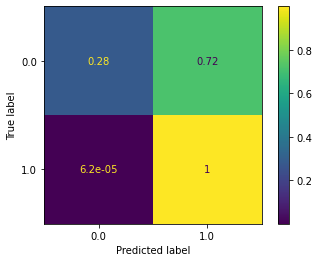

Prediction Accuracy:  0.2995805839623679
F1:  0.05800940478467518
Precision:  0.02987116041114194
Recall:  0.9999377916018662

Gaussian Naive Bayes (min-max data):


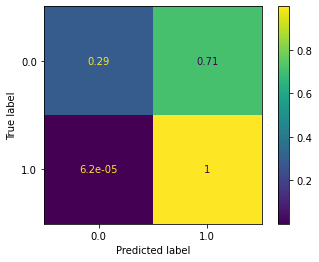

Prediction Accuracy:  0.30754023093374405
F1:  0.05863710856383043
Precision:  0.03020415142663599
Recall:  0.9999377916018662



In [7]:
from sklearn.naive_bayes import GaussianNB
from numpy import ravel

eff_gnb = []

for name, x_train, y_train, x_test, y_test in data_sets:
    y_train_ravel=ravel(y_train)
    gnb = GaussianNB().fit(x_train, y_train_ravel)
    pred = gnb.predict(x_test)
    print(f"Gaussian Naive Bayes ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_gnb.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model naiwny Bayessa przeuczył się względem próbek z klasy pozytywnej - poprawnie zaklasyfikowano prawie 100% próbek. Jednak spowodowało to bardzo niską skuteczność wykrywania próbek ujemnych - czyli lotów, które nie zostały odwołane - jedynie niecałe 30% z nich zostało przewidziane poprawnie. Trochę lepiej radził sobie model z danymi skalowanymi min-max, podobnie jak w poprzednim modelu, uzyskał on wynik o 1% lepszy niż model ze standardowym skalowaniem.

### LOGISTIC REGRESSION

Logistic Regression (standarized data):


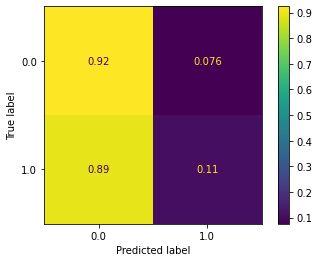

Prediction Accuracy:  0.906592050147453
F1:  0.046732938985650126
Precision:  0.029961198799094053
Recall:  0.10615863141524105

Logistic Regression (min-max data):


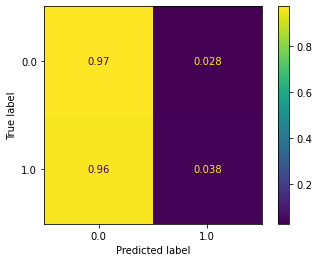

Prediction Accuracy:  0.9516396939846133
F1:  0.03266149593408658
Precision:  0.028721797413386197
Recall:  0.037853810264385696



In [8]:
from sklearn.linear_model import LogisticRegression
from numpy import ravel

eff_lr = []

for name, x_train, y_train, x_test, y_test in data_sets:
    y_train_ravel=ravel(y_train)
    lr = LogisticRegression(random_state=42, max_iter=5000, class_weight="balanced").fit(x_train, y_train_ravel)
    pred = lr.predict(x_test)
    print(f"Logistic Regression ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_lr.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model regresji logistycznej przeuczył się względem próbek z klasy negatywnej - poprawnie zaklasyfikowano ponad 90% próbek. Jednak spowodowało to bardzo niską skuteczność wykrywania próbek dodatnich - czyli lotów, które zostały odwołane - jedynie od 4 do 11 % z nich zostało przewidziane poprawnie. W tym przypadku rodzaj skalowania danych miał duży wpływ na jakość klasyfikacji - dane przeskalowane metodą standardową (czyli w przeciwieństwie do poprzednich dwóch modeli) zaklasyfikował o 8% więcej próbek pozytywnych od modelu ze skalowaniem metodą min-max, przy niższej o około 5% skuteczności przewidywania klasy negatywnej.

### RANDOM FOREST

Random Forest Classifier (standarized data):


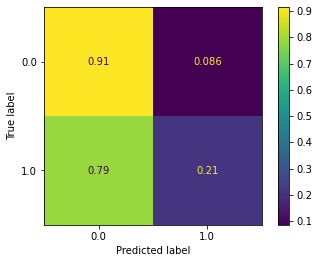

Prediction Accuracy:  0.8991986014098604
F1:  0.08331147240948052
Precision:  0.051819527188555384
Recall:  0.21237947122861586

Random Forest Classifier (min-max data):


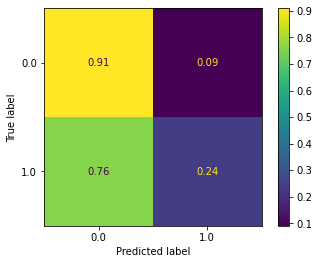

Prediction Accuracy:  0.8950426795398498
F1:  0.0893884012758131
Precision:  0.05498274405350059
Recall:  0.23884914463452567



In [9]:
from sklearn.ensemble import RandomForestClassifier
from numpy import ravel

eff_rfc = []

for name, x_train, y_train, x_test, y_test in data_sets:
    y_train_ravel=ravel(y_train)
    rfc = RandomForestClassifier(max_depth=10, random_state=42, class_weight="balanced", n_estimators=12, n_jobs=-1).fit(x_train, y_train_ravel)
    pred = rfc.predict(x_test)
    print(f"Random Forest Classifier ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_rfc.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model lasu losowego najlepiej ze wszystkich modeli poradził sobie z klasyfikacją odwołanych lotów. Poprawnie zostało zaklasyfikowane między 21 a 24% próbek dodatnich oraz 91% próbek ujemnych. Trochę lepsze wyniki zostały osiągnięte dla danych przeskalowanych metodą min-max - poprawnie sklasyfikowane zostało o 3% więcej próbek dodatnich. Mimo niższej skuteczności przewidywania klasy dodatniej, na podstawie wyniku F1 score można stwierdzić, że model lasu losowego ze skalowaniem min-max najlepiej ze wszystkich testowanych  poradził sobie z klasyfikacją danych dotyczących odwołanych lotów.

## WYNIKI

In [16]:
from prettytable import PrettyTable


def add_results(table, normalization_type, model, results):
    (acc, f1, prec, recall)= results
    table.add_row([normalization_type, model, round(acc, 5), round(f1, 5), round(prec, 5), round(recall, 5)])

def create_summary():
    summaryTable = PrettyTable(['normalization type', 'model', 'Accuracy', 'F1', 'Precision', 'Recall'])
    add_results(summaryTable, "standard", "Decision Tree Classifier", eff_dtc[0])
    add_results(summaryTable, "min-max", "Decision Tree Classifier", eff_dtc[1])
    add_results(summaryTable, "standard", "Gaussian Naive Bayes", eff_gnb[0])
    add_results(summaryTable, "min-max", "Gaussian Naive Bayes", eff_gnb[1])
    add_results(summaryTable, "standard", "Logistic Regression", eff_lr[0])
    add_results(summaryTable, "min-max", "Logistic Regression", eff_lr[1])
    add_results(summaryTable, "standard", "Random Forest Classifier", eff_rfc[0])
    add_results(summaryTable, "min-max", "Random Forest Classifier", eff_rfc[1])
    print(summaryTable)


In [17]:
create_summary()

+--------------------+--------------------------+----------+---------+-----------+---------+
| normalization type |          model           | Accuracy |    F1   | Precision |  Recall |
+--------------------+--------------------------+----------+---------+-----------+---------+
|      standard      | Decision Tree Classifier |  0.8354  | 0.07157 |  0.04074  | 0.29415 |
|      min-max       | Decision Tree Classifier | 0.82985  | 0.07083 |  0.04014  | 0.30068 |
|      standard      |   Gaussian Naive Bayes   | 0.29958  | 0.05801 |  0.02987  | 0.99994 |
|      min-max       |   Gaussian Naive Bayes   | 0.30754  | 0.05864 |   0.0302  | 0.99994 |
|      standard      |   Logistic Regression    | 0.90659  | 0.04673 |  0.02996  | 0.10616 |
|      min-max       |   Logistic Regression    | 0.95164  | 0.03266 |  0.02872  | 0.03785 |
|      standard      | Random Forest Classifier |  0.8992  | 0.08331 |  0.05182  | 0.21238 |
|      min-max       | Random Forest Classifier | 0.89504  | 0.08939 |

### STRATIFIED CROSS VALIDATION

In [24]:
def cross_validation_split(dataInput):
    cancelled = dataInput['Cancelled']==1
    dataCancelled = dataInput[cancelled]
    dataNotCancelled = dataInput[~cancelled]
    DF_x = pd.DataFrame(dataCancelled[:], columns = columns)
    DF_y = pd.DataFrame(dataNotCancelled[:], columns = columns)
    finalDF = DF_x.append(DF_y)
    finalDF = finalDF.sample(frac=1, random_state=42)
    finalDF = finalDF.to_numpy()
    return finalDF[:, :-1], finalDF[:, -1:]


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
def mp(test, predicted):
    tn=0
    tp=0
    fn=0
    fp=0
    for i in range(len(test)):
        if test[i] == predicted[i]:
            if test[i] == 0:
                tn += 1
            else:
                tp += 1
        else:
            if test[i] == 0:
                fn += 1
            else:
                fp += 1
    return tp, tn, fn, fp

def f1(tp, tn, fn, fp):
    return 2*(2*tp/(2*tp+fp+fn))/2

In [27]:
def cross_validation(df, k, classifier):
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    sum_f1_score = 0
    mod = len(df) % k
    if(mod != 0):
        df.drop(df.tail(mod).index,inplace=True)
    n = int(len(df) / k)
    resultSum = 0
    for i in range(k):
        test = df[i*n:(i+1)*n + 1]
        x_test, y_test = cross_validation_split(test)
        train = pd.concat([df[:i * n], df[(i+1) * n + 1:]])
        x_train, y_train = cross_validation_split(train)
        if classifier!= DecisionTreeClassifier(max_depth=10, class_weight="balanced"):
            y_train= ravel(y_train)
        classifier.fit(x_train,y_train)
        predictions = classifier.predict(x_test)
        sum_f1_score += f1_score(y_test, predictions)
        tp1, tn1, fn1, fp1 = mp(y_test, predictions)
        tp += tp1
        tn += tn1
        fn += fn1
        fp += fp1
        resultSum += classifier.score(x_test, y_test)
    print("Classification F1 - own implementation: " +  str(f1(tp, tn, fn, fp)))
    print("Classification F1 - build function: " +  str(sum_f1_score/k))
    return resultSum/k

In [28]:
from sklearn import preprocessing


def create_summary_cross_validation(n):
    summaryTable = PrettyTable(['scaler', 'model', 'K folds', 'cross validation score'])
    summaryTable.add_row(["standard", "Decision Tree Classifier", n,  cross_validation(data_standard, n, DecisionTreeClassifier(max_depth=10, class_weight="balanced"))])
    summaryTable.add_row(["min-max", "Decision Tree Classifier", n,  cross_validation(data_minmax, n, DecisionTreeClassifier(max_depth=10, class_weight="balanced"))])
    summaryTable.add_row(["standard", "Gaussian Naive Bayes", n, cross_validation(data_standard, n,  GaussianNB())])
    summaryTable.add_row(["min-max", "Gaussian Naive Bayes", n, cross_validation(data_minmax, n,  GaussianNB())])
    print(summaryTable)

In [29]:
create_summary_cross_validation(5)

Classification F1 - own implementation: 0.07602656186475132
Classification F1 - build function: 0.07878954555607519
Classification F1 - own implementation: 0.07667483432534626
Classification F1 - build function: 0.07520731322377108
Classification F1 - own implementation: 0.05877414183546071
Classification F1 - build function: 0.059054887292804094
Classification F1 - own implementation: 0.05932013773656266
Classification F1 - build function: 0.05959630228368264
+----------+--------------------------+---------+------------------------+
|  scaler  |          model           | K folds | cross validation score |
+----------+--------------------------+---------+------------------------+
| standard | Decision Tree Classifier |    5    |   0.718250077215809    |
| min-max  | Decision Tree Classifier |    5    |   0.6864883687234553   |
| standard |   Gaussian Naive Bayes   |    5    |   0.309457160655591    |
| min-max  |   Gaussian Naive Bayes   |    5    |   0.3168993142369123   |
+---------

In [44]:
from sklearn import preprocessing
cross_validation(data_with_nulls, preprocessing.StandardScaler(), 5,  DecisionTreeClassifier(max_depth=10, class_weight="balanced"))

0.7182504797264018